In [5]:
import pandas as pd
import feather

#######################################################
#################### READ CSV #########################

#df = pd.read_csv('./all/train.csv', parse_dates=['pickup_datetime'])

#######################################################
################## WRITE FEATHER ######################

#df.to_feather('./all/train.feather')

#######################################################
################## READ FEATHER #######################

#df = pd.read_feather('./all/train.feather')

In [6]:
# CHECK FOR INVALID COORDINATES (outside of NYC range)
# determined with https://www.mapdevelopers.com/geocode_bounding_box.php

def valid_coordinates(lat_list, lon_list):
    for i in lat_list:
        if i < 40.477399 or i > 40.917577:
            return False
    for i in lon_list:
        if i < -74.259090 or i > -73.700272:
            return False
    return True

def clean_coordinates(df):
    df.query('~(pickup_latitude < 40.477399 or pickup_latitude > 40.917577) &\
              ~(dropoff_latitude < 40.477399 or dropoff_latitude > 40.917577) &\
              ~(pickup_longitude < -74.259090 or pickup_longitude > -73.700272) &\
              ~(dropoff_longitude < -74.259090 or dropoff_longitude > -73.700272)', inplace=True)

In [7]:
# REMOVE INVALID PASSENGER COUNTS AND FARES, DROPNA, UNNEEDED KEYS

def clean_pfdk(df):
    df.drop(columns=['key'], inplace=True)
    df.dropna(inplace=True)
    df.query('passenger_count > 0 & passenger_count < 15 & fare_amount > 0 & fare_amount < 200 ', inplace=True)

In [8]:
# CALCULATE EUCLIDEAN DISTANCE

from scipy.spatial import distance

def euclidean_distance(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y2-y1)**2)**0.5

def add_euclidean_distance(df):
    df['euclidean_distance'] = euclidean_distance(df['pickup_latitude'], df['pickup_longitude'], 
                                                  df['dropoff_latitude'], df['dropoff_longitude'])

In [9]:
# EXTRACT TIME VALUES

def add_times(df):
    df['year']  = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day']   = df['pickup_datetime'].dt.day
    df['hour']  = df['pickup_datetime'].dt.hour + (df['pickup_datetime'].dt.minute/60)

In [10]:
# PREPROCESS PIPELINE

def preprocess(df, training=True):
    if training:
        clean_pfdk(df)
        clean_coordinates(df)
        df.reset_index(drop=True, inplace=True)
    add_euclidean_distance(df)
    add_times(df)

In [3]:
# PREPROCESS TRAINING DATA

#preprocess(df, training=True)

#######################################################

import pandas as pd
import feather

#######################################################
############## WRITE PREPROCESSED FEATHER #############

#df.to_feather('./all/preprocessed_train.feather')

#######################################################
######### READ PREPROCESSED FEATHER ###################

df = pd.read_feather('./all/preprocessed_train.feather')

In [11]:
# SPLIT TRAIN/TEST DATA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

def get_tt_split(size, scale_X=False):
    X = df.head(size)[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'year', 'month', 'day', 'hour', 'euclidean_distance', 'passenger_count']]
    y = df.head(size)['fare_amount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=3)
    if scale_X:
        X_train = scale(X_train)
        X_test  = scale(X_test)
    return X_train, X_test, y_train, y_test

In [16]:
# FIT THE MODEL AND SCORE (LINEAR REGRESSION)

from sklearn.linear_model import LinearRegression

model = LinearRegression()

X_train, X_test, y_train, y_test = get_tt_split(len(df), scale_X=False)
model.fit(X_train, y_train)

print('Score (R^2):', model.score(X_test, y_test))

Score (R^2): 0.8120229208664876


In [ ]:
# GET COEFFICIENTS AND INTERCEPT FROM LR MODEL
print('\nCOEFFICIENTS:')
for i in list(zip(X_test.columns, model.coef_)):
    print('{0}: {1}'.format(i[0], i[1]))
print('\nINTERCEPT:\n', model.intercept_)

In [ ]:
# XGBOOST (DECISION TREE ENSEMBLES)

import xgboost as xgb
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = get_tt_split(len(df), scale_X=False)
matrix_train = xgb.DMatrix(X_train, label=y_train)
model = xgb.train(params={}, dtrain=matrix_train)

test_predictions = model.predict(xgb.DMatrix(X_test))
print('R^2:', r2_score(y_test, test_predictions))

In [17]:
# NEURAL NETWORK

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.train import RMSPropOptimizer
from tensorflow.nn import relu
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = get_tt_split(10000, scale_X=True)

model = keras.Sequential([
    Dense(64, activation=relu, input_shape=(X_train.shape[1],)),
    Dense(64, activation=relu),
    Dense(1)])

optimizer = RMSPropOptimizer(0.001)
model.compile(loss='mse', metrics=['mse'], optimizer=optimizer)
model.fit(X_train, y_train, epochs=500, verbose=0)

test_predictions = [i[0] for i in model.predict(X_test)]
print('R^2:', r2_score(y_test, test_predictions))

C:\Users\milto\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


R^2: 0.8755909238714207


In [21]:
# PREPROCESS ACTUAL DATA
real_df = pd.read_csv('./all/test.csv', parse_dates=['pickup_datetime'])
preprocess(real_df, training=False)

#######################################################

# FIT MODEL TO ACTUAL DATA
selected_model = 'nn'
scaled = 'True'

real_X = real_df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'year', 'month', 'day', 'hour', 'euclidean_distance', 'passenger_count']]

if scaled:
    real_X = scale(real_X)

if selected_model == 'xgb':
    predictions = model.predict(xgb.DMatrix(real_X))

if selected_model == 'nn':
    predictions = [i[0] for i in model.predict(real_X)]

data = list(zip(real_df['key'], predictions))

submission = pd.DataFrame(data, columns=['key', 'fare_amount'])
submission.set_index('key', inplace=True)
submission.to_csv('submission.csv')

In [31]:
df = df.head(10000)

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

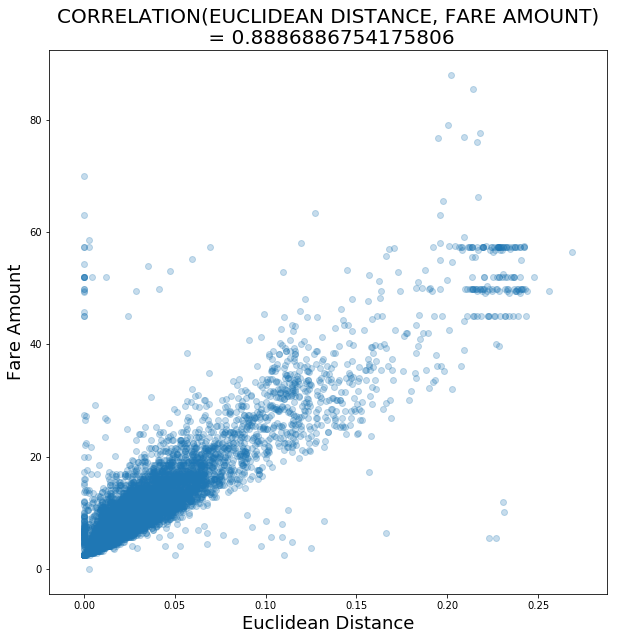

In [33]:
# SCATTER PLOT
# (EUCLIDEAN DISTANCE, FARE AMOUNT)

corr = df['euclidean_distance'].corr(df['fare_amount'])
plt.figure(figsize=(10,10))
plt.scatter(df['euclidean_distance'], df['fare_amount'], alpha=0.25)
plt.title('CORRELATION(EUCLIDEAN DISTANCE, FARE AMOUNT)\n = {0}'.format(corr), fontsize = 20)
plt.xlabel('Euclidean Distance', fontsize=18)
plt.ylabel('Fare Amount', fontsize=18)
plt.show()

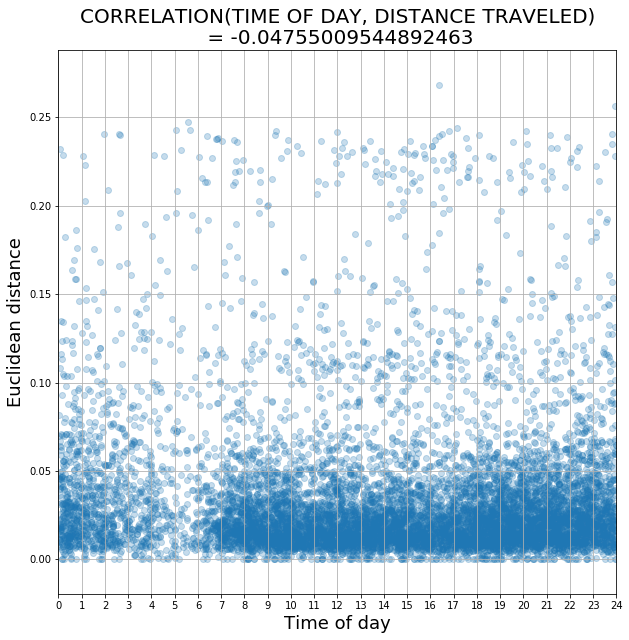

In [34]:
# SCATTER PLOT
# (TIME OF DAY, DISTANCE TRAVELED)

corr = df['hour'].corr(df['euclidean_distance'])
plt.figure(figsize=(10,10))
plt.scatter(df['hour'], df['euclidean_distance'], alpha=0.25)
plt.title('CORRELATION(TIME OF DAY, DISTANCE TRAVELED)\n = {0}'.format(corr), fontsize = 20)
plt.xlabel('Time of day', fontsize=18)
plt.ylabel('Euclidean distance', fontsize=18)
plt.xlim(0,24)
plt.xticks(range(0,25))
plt.grid(True)
plt.show()

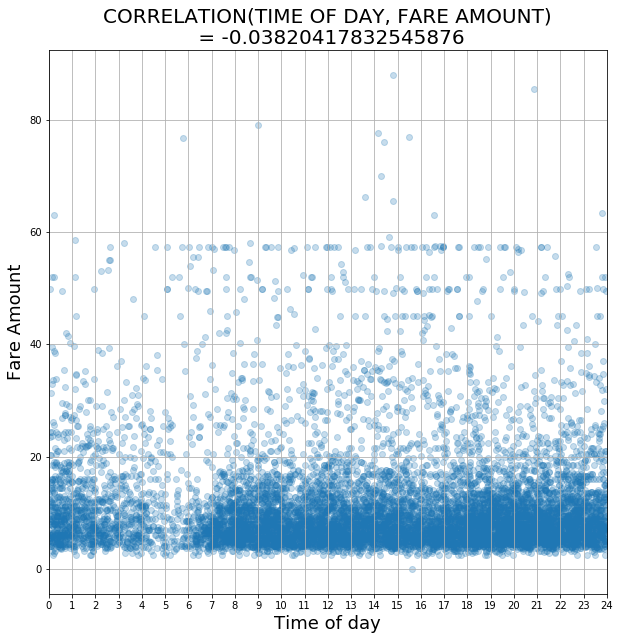

In [35]:
# SCATTER PLOT
# (TIME OF DAY, FARE AMOUNT)

corr = df['hour'].corr(df['fare_amount'])
plt.figure(figsize=(10,10))
plt.scatter(df['hour'], df['fare_amount'], alpha=0.25)
plt.title('CORRELATION(TIME OF DAY, FARE AMOUNT)\n = {0}'.format(corr), fontsize = 20)
plt.xlabel('Time of day', fontsize=18)
plt.ylabel('Fare Amount', fontsize=18)
plt.xlim(0,24)
plt.xticks(range(0,25))
plt.grid(True)
plt.show()

In [36]:
# CORRELATION MATRIX

corr_matrix = df.corr()
corr_matrix

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,year,month,day,hour
fare_amount,1.000000,0.416875,-0.211600,0.318863,-0.156979,0.017820,0.888689,0.110052,0.041424,-0.000549,-0.038204
pickup_longitude,0.416875,1.000000,-0.033941,0.296270,0.043143,0.015453,0.455872,0.021309,0.011468,0.006080,0.035055
pickup_latitude,-0.211600,-0.033941,1.000000,0.038964,0.418094,-0.005514,-0.243263,-0.000170,-0.003941,-0.022085,0.033100
dropoff_longitude,0.318863,0.296270,0.038964,1.000000,0.146793,0.005023,0.387692,0.011307,0.016741,0.011028,-0.046826
dropoff_latitude,-0.156979,0.043143,0.418094,0.146793,1.000000,-0.000129,-0.136296,0.004222,0.002432,-0.007906,0.021699
passenger_count,0.017820,0.015453,-0.005514,0.005023,-0.000129,1.000000,0.014364,-0.004449,0.004760,-0.000927,0.011543
euclidean_distance,0.888689,0.455872,-0.243263,0.387692,-0.136296,0.014364,1.000000,0.017945,0.027455,0.002777,-0.047550
year,0.110052,0.021309,-0.000170,0.011307,0.004222,-0.004449,0.017945,1.000000,-0.113974,-0.028114,-0.000418
month,0.041424,0.011468,-0.003941,0.016741,0.002432,0.004760,0.027455,-0.113974,1.000000,-0.018321,-0.004636
day,-0.000549,0.006080,-0.022085,0.011028,-0.007906,-0.000927,0.002777,-0.028114,-0.018321,1.000000,-0.001020


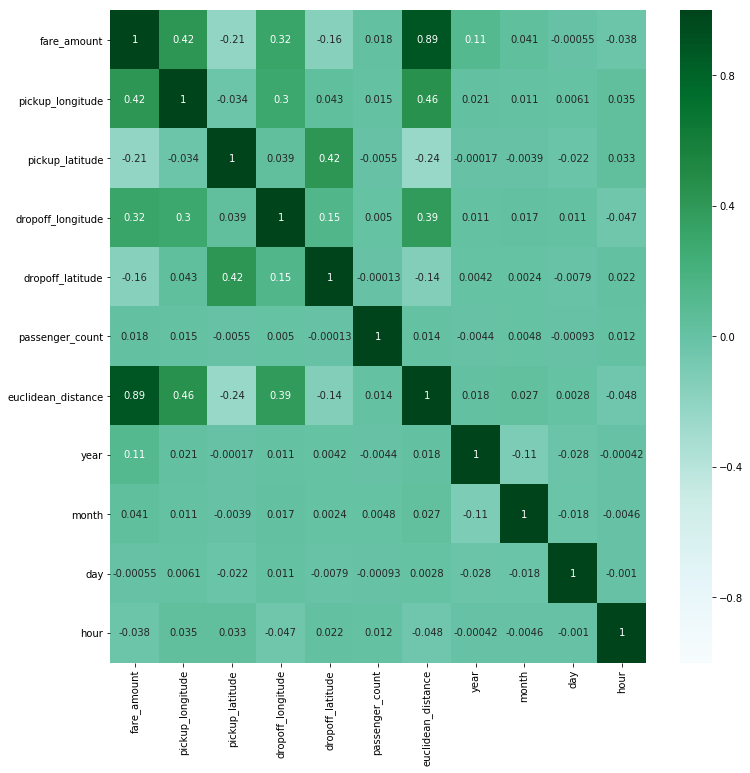

In [37]:
# CORRELATION HEATMAP

plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, cmap='BuGn', annot=True, vmin=-1, vmax=1)
plt.show()

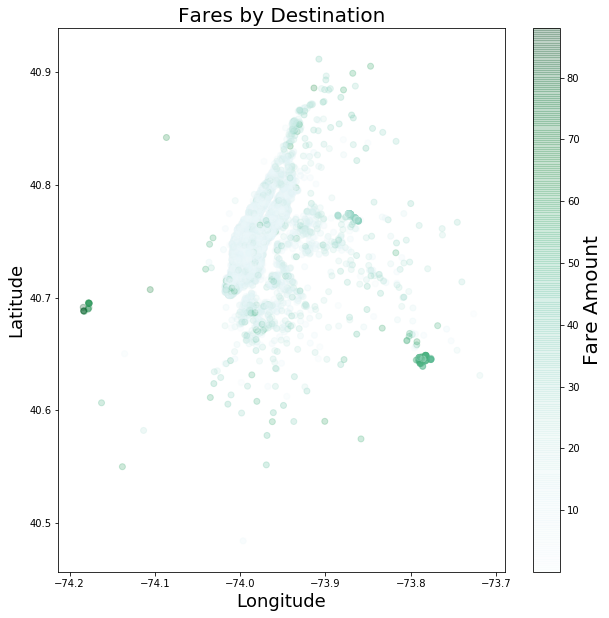

In [39]:
# PLOT FARES BY DESTINATION

plt.figure(figsize=(10,10))
plt.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c=df['fare_amount'], cmap=plt.get_cmap("BuGn"), alpha=0.25)
colorbar = plt.colorbar()
colorbar.ax.set_ylabel('Fare Amount', fontsize=20)
plt.title('Fares by Destination'.format(corr), fontsize = 20)
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.show()